# Подбор кандидатов

**Определить вероятность насколько кандидаты подходят к вакансии.**
Т.е. вход: 1 ваканасия и много кандидатов, надо определить для каждого кандидата вероятность насколько он подходит 


Модель принимает на вход список кандидатов и вакансию, возвращает список кандидатов отсортированных по метрике (от 0 до 1) соответствия предлагаемой вакансии от максимального соответствия к минимальному

Требования: 
Время работы ранжирования модели при входных параметрах 1 вакансия, 10 кандидатов - не более 1с

TODO: 
Обработка данных
- добавить параметр стаж работы
- управлять весами параметров

In [1]:
# Установка библиотек для Colab
! pip install nltk
! pip install matplotlib
! pip install sklearn
! pip install re
! pip install difflib
! pip install tensorflow
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=1c2d22c5e454512198020db9c7d547163b2f3b4b014ef09638f1fefb20e7d2f2
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement difflib (from versions

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Библиотека SkLearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Обработка текстовой инмформации
import re
import difflib

# Библиотека CatBoost
from catboost import CatBoostRegressor

# Библиотеки Tensorflow
import tensorflow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# Библиотеки для обработки текстов
# import transformers
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
rus_stopwords = stopwords.words("russian")
snowball = SnowballStemmer(language="russian")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Функция опредления уровня схожести между строками (коэффициент Танимото), как альтернатива difflib
def tanimoto(s1, s2):
    if len(s1) == 0 and len(s2) == 0:
      return 0 
    a, b, c = len(s1), len(s2), 0.0
    for sym in s1:
        if sym in s2:
            c += 1
    return c / (a + b - c)

## Загружаем и формируем данные

Формируем словарь статус => вероятность соответствия кандидата вакансии

In [4]:
# Словарь статус - вероятность соответствия кандидата вакансии
default_fillna_status_weight = 0
negative = 0
other = 0.6
otklonen = 0.8
otklonen_vozrast = 0.83
otklonen_zdorovye = 0.9
otklonen_sb = 0.93
etap_resume = 0.95
interview_ne_sostoyalos  = 0.85
interview  = 0.97
kandidat_sam_otklonil = 0.95
na_rassmotrenii = 0.98
odobren = 0.99
prinyat = 1
list_status_weight = [
(negative, ["Negative row"]),
(other, ['unicnow', 'unknown', 0, '', None, 'нет КИСАРТ','Лендинг','Архив','в архив','нет КИСАРТ','Архив','в архив','Название компании',],),
(otklonen, ['Отклонен','Отказ по резюме','Отклонение кандидата','Отклонён по резюме','Отклонён по интервью','Отклонен руклем: опыт','ОтклоненПрофнавыки','ОтклоненCIT','ОтклоненAG','Отклонен CIT/AG','ОтклоненДругое','Собеседование с Заказчиком  Кандидат отклонен','Отклонен после рассмотрения резюме заказчиком','Отклонён после ТИ','Кандидат отклонен','Отклонен после телефонного интервью','Интервью c HR состоялось  Кандидат отклонен','Собеседование с HR   Кандидат отклонен','Не согласован','Не согласован CV','Не согласовано','Отказ РЦ','Отказ руководителя','Самоотказ МП','Самоотказ ОО','Отказ HR','Отказ (архивный статус)','Отказ','Отказ hrдругое (комментарии)','Отказ HRличн качества','Отказ HRдругоекомментарии','Отказ TA (телинтю)','Отказ ВВСС (другое)','Отказ заказчиком','Полиграф ОТКАЗ','Собеседование ОТКАЗ','Отказ работодателя','Отказ рекрутера по SOFT skills','Отказ рекрутера по HARD skikks','Отказ (заказчик)','Отказ после собеседования','Отказ по итогам собеседования с рекрутером','Отказ по итогам скрининга резюме','Отказ компании','Отказ заказчика','Отказ Advisability','ОТКАЗ СЦ','Отказ рекрутера АНКОР','Отказ ДЭБ','Отказ "ТИ"','Отказ "Новый"','УДАЛИТЬ Отказ по документам','Отказ "На расс заказчика"','УДАЛИТЬ Отказ','Отказ на этапе собеседования','Отказ "Инт с заказчиком"','Отказ нерелевантный опыт','Отказ по личностным качествам','Собеседование с заказчиком Отказ','Отказ по итогам испытательного срока','ТИ Отказ рекрутера Опыт','ТИ Отказ рекрутера Национальность','Тестирование не справился','Снят с рассмотрения','Мо не пройден','МК пройдена Не допущен','Не прошел стажировку','Не прошел первичный отбор','Площадку не сдал','Не требуется (тестовое задание)','Не требуется (заказчик)','Неадекват','Не прошёл по компетенции','Нет документов','Нет полного пакета документов','Нет гражданства РФ','Неприемлемые личные качества','Не ГПХ/СТД/ИП/СЗ','Отмена приема','Примечание','Уволен','Имеются риски','Полиграф','Черный список','Гражданство','Опыт','Другое','Речь','Судимость','Есть судимость','По личностным качества',],),
(otklonen_zdorovye,['Отказ по здоровью','Здоровье','Медосмотр','Результат медкомиссии','Медкомиссия',],),
(otklonen_sb, ['Отклонен СБ','Не согласован (Проверка СБ)','Не согласован СБ','Отказ СБ','СБ ОТКАЗ','Отказ  на финальном этапе (стаж, СБ, рекомендации, PIF)','Отказ (СБ)','Отказ проверка СБ','СБ отказ','Не прошёл СБ',],),
(otklonen_vozrast, ['УДАЛИТЬ Отказ по возрасту/полу УДАЛИТЬ','ТИ Отказ рекрутера Возраст','Не подходит по возрасту','Возраст',],),
(etap_resume, ['Резюме у заказчика','Составить резюме','Рассмотрение резюме','Первичный отбор по резюме/короткий звонок','Показ резюме','Скрининг резюме','Резюме отобрано','Приглашение','Приглашен','Отправлено письмо с приглашением','Приглашен на собеседование','Направлено приглашение','ТД приглашен','Приглашен на ТУ','Обзвон','Обзвон состоялся','Обзвон не состоялся','Одобрен Обзвон','Резерв Обзвон','Результат обзвона','Записан на собеседование','Назначено  собеседование заказчика','Недозвон','Не дозвонились','Скрининг по телефону  Недозвон','Тотальный недозвон','Не выходит на связь','РАЗОБРАТЬ Недозвон  день','Некорректный номер','Резерв  Внешний','Предложение','Резерв','Перезаписался','Резерв РЦ','Перенес обучения','Перезвонить','Направлено письмо кандидату','Анкету не заполнил','Написано письмо','Связаться','Отобран на вакансию','Пригласить','Релевантное','Дата посещения медцентра','ОТОБРАН НА ВАКАНСИЮ','Резерв ИР','Первичный отбор','РЕЗЕРВ','Запрос Анкеты','Жду ответа по CV','Жду ответа от соискателя','ОС кандидату','Скрининг по телефону','Первичный контакт','Кадровый резерв','Контакт установлен','Первый контакт','Чужой номер','Отправлено письмо','Отклик с Сайта','Отклик',],),
(interview_ne_sostoyalos, ['Тел интервью не состоялось Сообщение в ваццап','Тел интервью не состоялось Отправлено смс','Интервью не состоялось','Интервью (заказчик) не сост','Интервью у заказчика не состоялось','Интервью с заказчиком Не состоялось','Телефонное интервью не состоялось','Не прошел собеседование','Собеседование отменено','Не дошел на собеседование','Собеседование не состоялось','Собеседование с HR не состоялось','Собеседование с Заказчиком не состоялось','Перенесено собеседование','ТИ не сост',], ),
(interview, ['Интервью (рекрутер)','Интервью (заказчик)','Интервью','Интервью состоялось','Телефонное интервью','Интервью с заказчиком','Интервью с заказчиком Состоялось','Интервью с рекрутером Состоялось','Интервью с рекрутером','Интервью у заказчика','Интервью у заказчика состоялось','Интервью (заказчик) сост','Интервью (HR)','Интервью (руководитель функции)','Интервью (очное, скайп)','Интервью с непосредственным руководителем','ТА интервью','Интервью с НМ','Интервью с HR','Интервью с директором','Телефонное интервью ОК','Интервью с нач колонным','Интервью HR','Интервью состоялось Низохина','Интервью состоялось Козеровская','Результат интервью с рекрутером','Результат интервью с Заказчиком','Интервью с нанимающим менеджером','Приглашен (тел интервью)','Кандидат думает (тел интервью)','Скрининг по телефону  Приглашен на интервью','Тел интервью запланировано','Одобрен после телефонного интервью','Интервью с Заказчиком','Одобрен после интервью с Заказчиком','Телефонное интервью состоялось','Телефонное интервью перезвонить','Интервью назначено','Интервью с руководителем','Интервью с HR состоялось  Кандидат одобрен','Видеоинтервью','Решение по итогам интервью','Тел интервью состоялось Приглашен к Заказчику','Пришел','Пришел (повторно)','Пришел ОА','Пришел ОО','Перенес обучение: пришел','ТИ сост','Тел Инт','Инт с HR','Групповое инт','Кандидат','Уже общался','Направлен клиенту','Годен','Представление Заказчику''Передан заказчику''Общение по вакансии','Дошел до клиента','Инт с заказ',],), 
(kandidat_sam_otklonil, ['Принял предложение другой компании','Оффер не принят','Предложение отклонено','Оффер отклонен','Неявка на интервью','Не пришел на интервью у заказчика','Не пришел на интервью у рекрутера','Телефонное интервью САМООТКАЗ','Телефонное интервью ОТКАЗ','Отказ кандидата после интервью с Заказчиком','Отказ кандидата после интервью с рекрутером','Не ответил (тел интервью)','Отказ рекрутера (тел интервью)','Отказ кандидата (тел интервью)','Самоотказ после телефонного интервью','Самоотказ после интервью','Кандидат не пришел на встречу','Не пришел (заказчик)','Не пришел ОО','Не пришел','Не пришел (повторно)','Перенес обучение: не пришел','Не отвечает','Приглашение  Кандидат не ответил','Отказ кандидатаУровень дохода','Отказ кандидатаДругое','Отказ кандидата Условия работы','ТИ Самоотказ Местонахождение','ТИ Самоотказ Уровень ЗП','ТИ Самоотказ График работы','ТИ Самоотказ Репутация компании','Отказ не интересны должностные обязанности','Собеседование с HR   Отказ кандидата','Испытательный срок  Отказ кандидата','Собеседование с Заказчиком  Отказ кандидата','Отказался/Нашел работу','Отказ кандидатауровень зп','Отказ по ЗП','Отказ не в поиске','Отказ кандидата','Самоотказ','Отказ кандидата график','Отказ кандидата поиск не актуален','Отказ кандидата прочие причины','Отказ кандидата  территория','Отказ кандидата ЗП','Отказ кандидата по функционалу','Отказ кандидата (телинтю)','Отказ кандидата (другой этап)','Отказ кандидата (другое)','Собеседование САМООТКАЗ','Отказ месторасположение офиса','Отказ не нравится компания','Отказ несоответствие зарплатным ожиданиям','Отказ по графику','Не заключил договор','Расторгнул договор','Неактуально','Не пришёл','Не интересен металлопрокат','Не ищет работу','Не устраивает график','Нерелевантное','Не подходят условия','Не в поисках работы','По другой причине','Не подходит график','Неудобное местоположение','УДАЛИТЬ Не актуален поиск работы УДАЛИТЬ','УДАЛИТЬ Не подошли условия УДАЛИТЬ','УДАЛИТЬ Не устраивает локация УДАЛИТЬ','УДАЛИТЬ Нерелевантный опыт УДАЛИТЬ','Не подходит сфера деятельности компании','Не такси','За авто','МКАД','За МКАД','Дорого','Высокие ЗПО','Декрет','Функционал','Выбрал другую компанию','Территория','Сфера деятельности компании','Отказ кандидата по интервью','Отказ после телефонного интервью','Отказ по итогам интервью с Заказчиком','ОТКАЗ ДО ИНТЕРВЬЮ У КЛИЕНТА','ОТКАЗ ПОСЛЕ ИНТЕРВЬЮ У КЛИЕНТА','Отказ по интервью ТА','Самоотказ РЦ','Отказ соискателя','Скрининг по телефону  Отказ рекрутера','Скрининг по телефону  Отказ кандидата','Отказ рекрутером','Отказ не актуально предложение',], ),
(na_rassmotrenii, ['Думает РЦ','Думает МП','Думает','Подумать','Подумает','Кандидат думает','РАЗОБРАТЬ Думает','Тестирование','Тестирование пройдено','Проверка СБ','Отправлен на проверку в СБ','Отправлен на проверку (СБ)','Проверка службы безопасности','СБ ПРОВЕРКА','Рекомендован к дальнейшему рассмотрению','На рассмотрении у заказчика','Рекомендован к рассмотрению руководителю','На рассмотрении заказчика','Рассмотрение Руководитель группы массподбора','СБ','Отправлен на СБ','на сб (через сайт)','Отправка на СБ','Отправлен в СБ','Сбор документов','Сброс звонка','СБ  этап','Резерв после СБ','Назначено собеседование в ресторан','Назначено собеседование в офис','Собеседование','Кандидат был на собеседовании, ждет ОС','Собеседование прошел (директор статус не поставил)','Собеседование с Заказчиком состоялось','Собеседование с HR состоялось','СОБЕСЕДОВАНИЕ С HR','СОБЕСЕДОВАНИЕ С ЗАКАЗЧИКОМ','Очное собеседование','Собеседование ОК','Собеседование состоялось','Собеседование с рекрутером','Собеседование с Заказчиком','Собеседование с заказчиком','Заполнил анкету, директор не подходил','Риски не выявлены','Вопрос клиенту','Сдача площадки','Направлен на медкнижку','Представлен НМ','Получено из ЛО МВД','Отправлено в ДЭБ','Направлен на медкомиссию','Отправлено в ЛО МВД','Отправлено в Отдел пропусков','Замена авто','Скрининг','Тестовое задание','Ожидание справок','Сделан сорсинг (КВАЛ)','Результаты встречи у заказчика','Результат ТЗ, ассессмент, кейсок','Результат ТЗ, ассессмент, кейс','Направлен на МО','Мед осмотр','Направлен на мед комиссию','Директор проставил неверный статус','Лендинг','GBC','КДП','ДЭБ','МК','ТИ состоялось','ИсР Состоялось','Назначен на  этап','Просмотрен Заказчиком','направление на флюорографию','ой этап','Директор проставил неверный статус',], ),
(prinyat, ['Телефонное интервью Одобрен','Принят на работу','Предложение принято','Принят на работу после ИС','Оффер принят','ПРИНЯТ НА РАБОТУ','Принят в работу','Кандидат принят на работу','Принят','Резюме принято заказчиком','Заключил договор','Заключил договор (повторно)','На оформление','Оформился','Оформлен','Отправлен на оформление','Оформление в ОТОиКУ','Оформление','Оформление (передача кадровикам)','Тип оформления','Оформление в штат (офис)','Вышел на линию','Вышел на линию (повторно)','Вышел на ИС','Кандидат вышел','Вышел на стажировку','Вышел на работу','Не вышел на линию','Не вышел на линию (повторно)','Не вышел на стажировку','Кандидат не вышел на работу','Не вышел на связь/Не дозвониться','Кандидат не вышел','Испытательный срок','Нанят','ПОДПИСАНИЕ ЗАЯВЛЕНИЯ','Вызван на стажировку','Стажировка','ОФФЕР','Трудоустройство','Стажёр','Пробный день','Прошел обучение','Прошел','Отправка оффера кандидату','Выход на работу','Оффер','Трудоустроен','ИСПЫТАТЕЛЬНЫЙ СРОК',],),
(odobren, ['Согласован','Согласование CV','Согласование','Согласован CV','Согласован (Проверка СБ)','Согласование СБ','Согласовано','Согласование резюме с руководителем','Согласование кандидата с заказчиком','Пропуск согласован','Согласован на следующий этап после обзвона','Согласован рекрутером','Согласован  Заказчиком','Согласован заказчиком','Согласовано ДЭБ','Согласован (рекрутер)','Согласован (заказчик)','Согласован (СБ)','Согласование Заказчиком','СБ согласован','ТелИнт согласован','Инт с HR согласован','СБ  этап согласован','Групповое инт согласован','ТД согласован','Инт с заказ  согласован','Кандидат согласован','Приглашение на оформление','Одобрен заказчиком','Кандидат одобрен HR','Одобрен ИР','Полиграф ОДОБРЕН','СБ  одобрен','Одобрен','Одобрен (скрининг)','Одобрен клиентом','Кандидат одобрен заказчиком','Одобрен Ирина','Собеседование с заказчиком Одобрен','Кандидат одобрен Заказчиком','ИС пройден','Мо пройден','Испытательный срок пройдет','МК пройдена Допущен','СБ ok','СБ ОК','СБ Норм','Прошел СБ','СБ nok','Предложение о работе','Площадку сдал','На своем авто','Документы переданы в кадры','Прошел стажировку','Утверждение руководителем','Стажировку прошёл(а)',],),]

status_weight = []
for weight, statuses in list_status_weight:
  for status in statuses:
    status_weight.append([status, weight])
df_status_weight = pd.DataFrame(status_weight, columns=["status", "status_weight"])

Заргужаем данные из csv

In [5]:
# Подключение Гугл-диска.
#  Надо подключить эту папку: https://drive.google.com/drive/folders/1dlYYOK4Yw_EtKTb-2W736s6vDhUTxCJg?usp=sharing, можно сделать у себя ссылку на неё и обращаться как обычно (по сути добавить ярлык на папку)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH_PROJECT = "drive/MyDrive/Skolkovo Hack 2022/"

# Кандидаты используется расчширенный датасет (подготовленный отдлеьным скриптом)
# filename_candidates = PATH_PROJECT + "dataset/" + "big_ext_data_candidates.csv"
filename_candidates = PATH_PROJECT + "dataset/" + "ext_data_candidates.csv"
# данные по образованию кандидатов
filename_education = PATH_PROJECT + "dataset/" + "data_candidates_education.csv"
# места работы кандидатов
filename_work_places = PATH_PROJECT + "dataset/" + "data_candidates_work_places.csv"
# Вакансии
filename_jobs = PATH_PROJECT + "dataset/" + "data_jobs.csv"

In [7]:
candidates_df = pd.read_csv(filename_candidates, sep=";", names=['id', 'position', 'sex', 	
                                                                 'citizenship', 	'age', 'salary',	
                                                                 'langs', 'driver_license', 'subwey', 
                                                                 'skills', 'employment', 'shedule', 
                                                                 'candidate_region', 'date_created', 
                                                                 'job_id', 'candidate_status_id', 'status'], skiprows=[0])
education_df = pd.read_csv(filename_education, sep=";", names=['id', 'university', 'faculty', 'graduate_year'])
work_places_df = pd.read_csv(filename_work_places, sep=";", names=['id', 'work_place_position', 'from_year', 	'from_month', 'to_year', 'to_month'])
jobs_df = pd.read_csv(filename_jobs, sep=";", names=['job_id', 'job_status', 'job_name', 	'job_region', 'job_description'])

candidates_df.shape, education_df.shape, work_places_df.shape, jobs_df.shape

((122047, 17), (24514, 4), (69758, 6), (648, 5))

In [8]:
# candidates_df["id"] = candidates_df["id"].astype(int)
# union_df['salary']
# candidates_df.head(5)

Удаляем дубли в данных (Дубли определяются по Id)

In [9]:
# Удаление дублей по Id
candidates_mask = candidates_df.duplicated(subset=["id", "job_id"])
candidates_df = candidates_df.loc[~candidates_mask]

education_mask = education_df.duplicated(subset=["id"])
education_df = education_df.loc[~education_mask]

work_places_mask = work_places_df.duplicated(subset=["id"])
work_places_df = work_places_df.loc[~work_places_mask]

jobs_mask = jobs_df.duplicated(subset=["job_id"])
jobs_df = jobs_df.loc[~jobs_mask]

status_weight_mask = df_status_weight.duplicated(subset=["status"])
df_status_weight = df_status_weight.loc[~status_weight_mask]

candidates_df.shape, education_df.shape, work_places_df.shape, jobs_df.shape, df_status_weight.shape

((122047, 17), (17601, 4), (21683, 6), (648, 5), (533, 2))

# Генерация дополниетлных данных
На вход системе поданы относительно "позитивные" данные, когда кандидат был рассмотрен на должность, т.е. заведомо связанные данные вакансии и кандидата. Однако для поиска признака на сколько подходят вакансия и кандидат необходмио иметь негативный набор данных. Его можно сгенерировать из существующих данных.

За основу негативных данных можно взять такие связь вакансия-кандидат, у которых схожесть в названии вакансий маскимально низкая


Генерация данных реализована в отдельном файле: generate_negative_data.py

# Обрабатываем данные

Объединяем все таблицы в одну

In [10]:
# объединяем кандидатов с данными об образовании (по "id")
union_df = candidates_df.merge(education_df, how="left", left_on="id", right_on="id")

# объединяем кандидатов с данными об опыте работы (по "id")
union_df = union_df.merge(work_places_df, how="left", left_on="id", right_on="id")

# объединяем кандидатов с данными по вакансии (по "job_id")
union_df = union_df.merge(jobs_df, how="left", left_on="job_id", right_on="job_id")

# объединяем кандидатов с весами по статусам (по "status")
union_df = union_df.merge(df_status_weight, how="left", left_on="status", right_on="status")
union_df.status_weight = union_df.status_weight.fillna(default_fillna_status_weight)

union_df.shape

(122047, 30)

Обеспечиваем, что текстовые поля точно текстовые

In [11]:
union_df["position"] = union_df["position"].astype({"position": 'str'})
union_df["job_name"] = union_df["job_name"].astype({"job_name": 'str'})
union_df["skills"] = union_df["skills"].astype({"skills": 'str'})
union_df["job_description"] = union_df["job_description"].astype({"job_description": 'str'})

In [12]:
# for CatBoost
union = union_df.copy()

# Предобработка данных

## Корректируем данные

#### Корректируем данные Возраста

In [13]:
# Будем править Возраст по правилам: если больше > 70, то 70 если меньше 0, то 0, если от 1 до 18 то 18
union_df.loc[union_df['age'] > 70, 'age'] = 70
union_df.loc[union_df['age'] < 0, 'age'] = 0
union_df.loc[(union_df['age'] > 0) & (union_df['age'] < 18), 'age'] = 18
union_df.age.unique()

array([23, 31, 27, 28, 22,  0, 21, 29, 30, 24, 46, 52, 49, 48, 39, 45, 38,
       35, 42, 43, 32, 41, 40, 37, 34, 33, 50, 44, 51, 47, 36, 25, 20, 26,
       59, 56, 54, 60, 55, 58, 53, 18, 57, 61, 19, 64, 62, 65, 63, 68, 66,
       70, 67])

#### Корректируем данные по Зарплате

In [14]:
# Будем править Зарплату по правилам: если больше 0 но меньше 20000, то 20000, если больше 200 000 то 200 000
union_df.loc[union_df['salary'] > 200000, 'salary'] = 200000
union_df.loc[(union_df['salary'] > 0) & (union_df['salary'] < 20000), 'salary'] = 20000
union_df.salary.unique()

array([     0,  45000,  40000,  35000,  50000,  25000,  30000,  55000,
        36000,  29500,  41000,  60000,  28000,  20000,  38000,  90000,
        45999,  33333,  42000,  65000,  37000,  33000,  39000,  80000,
        70000,  75000,  23000,  29600,  22000,  24000,  21000,  24500,
       100000,  27000,  32500,  72999,  32000,  29000,  31000,  49000,
        46000,  34500,  43000,  53000,  48000, 150000,  95000,  26000,
        29999,  22500,  28500,  22222,  99999,  30400,  85000, 200000,
        28522,  30009,  45800, 120000, 140726,  26500,  34000, 110000,
        99000,  25800,  51000,  38400,  72000,  32900,  44000,  31999,
       115000,  47000,  27500,  25555,  78000, 160000,  22777,  24200,
        65500,  51500,  42500,  60100,  57000,  79000, 130000, 180000,
       113000, 116000,  58000,  77777,  44500, 123456,  50999,  87000,
        63000,  83000,  69000,  67000, 140000,  68000,  52500, 101000,
        98200,  66000, 105000, 177000,  69900,  77000,  76000,  99990,
      

#### Корректируем данные по Категориям прав

In [15]:
# для кандидатов водителей ставим по умолчанию права ставим на категорию "B"
union_df.loc[union_df['position'].astype(str).str.contains("Водит|водит|авто|дитель|такс|ВОДИТ|Перегон|ПЕРЕГОН|перегон|Трактор|ТРАКТОР|трактор|Перевоз|ПЕРЕВОЗ|перевоз"), 'driver_license'] = union_df.loc[union_df['position'].astype(str).str.contains("Водит|водит|авто|дитель|такс|ВОДИТ|Перегон|ПЕРЕГОН|перегон|Трактор|ТРАКТОР|трактор|Перевоз|ПЕРЕВОЗ|перевоз"), 'driver_license'].fillna("B")

Права могут быть различных категорий, указываем каждый тип прав как отдельны столбец

In [16]:
# Права могут быть различных категорий, указываем каждый тип прав как отдельны столбец
union_df['driver_license_BE'] = np.where(union_df['driver_license'].astype(str).str.contains("BE|Be|bE|be|ВЕ|ве|Ве|вЕ") , 1, 0)
union_df['driver_license_DE'] = np.where(union_df['driver_license'].astype(str).str.contains("DE|de|De|dE|DЕ|dе|Dе|dЕ") , 1, 0)
union_df['driver_license_CE'] = np.where(union_df['driver_license'].astype(str).str.contains("CE|ce|Ce|cE|СЕ|се|Се|сЕ") , 1, 0)
union_df['driver_license_E'] = np.where(union_df['driver_license'].astype(str).str.contains("E|e|Е|е") , 1, 0)
union_df['driver_license_D'] = np.where(union_df['driver_license'].astype(str).str.contains("D|d") , 1, 0)
union_df['driver_license_C'] = np.where(union_df['driver_license'].astype(str).str.contains("C|c|С|с") , 1, 0)
union_df['driver_license_B'] = np.where(union_df['driver_license'].astype(str).str.contains("B|b|В|в") , 1, 0)
union_df['driver_license_A'] = np.where(union_df['driver_license'].astype(str).str.contains("A|a|А|а") , 1, 0)

In [17]:
union_df[3110:3115][["position", "driver_license" ,"job_name", 'driver_license_BE', 'driver_license_DE', 'driver_license_CE', 'driver_license_E', 'driver_license_D', 'driver_license_C', 'driver_license_B', 'driver_license_A']]

,position,driver_license,job_name,driver_license_BE,driver_license_DE,driver_license_CE,driver_license_E,driver_license_D,driver_license_C,driver_license_B,driver_license_A
3110,"Кладовщик, комплектовщик, работник склада, про...",NaN,Водитель Воронеж,0,0,0,0,0,0,0,1
3111,Менеджер,NaN,Водитель Воронеж,0,0,0,0,0,0,0,1
3112,Мастер участка,NaN,Водитель Воронеж,0,0,0,0,0,0,0,1
3113,Водитель-курьер с личным автомобилем,B,Водитель Воронеж,0,0,0,0,0,0,1,0
3114,водитель,B,Водитель Воронеж,0,0,0,0,0,0,1,0


#### Корректируем данные по Образованию

По образованию будет упрощенный варинат: будет три столбца: школа, технарь, универ.

Если в текстовом описании данных по обучению есть намек на универ, значит ставим три единицы (школа+ технарь + универ)

Если описание обучения есть у кандидата, но там нет намека на универ и нет слов со школой, то ставим две единицы в столбцах школа и технарь

Подразумеваем что школу окончили все, раз резюме смогли написать. Таким образом этот параметр нет смысла учитывать во входных параметрах так как он будет у всех

In [18]:
# Корректируем данные по Образованию
union_df['high_education'] = np.where(union_df['university'].astype(str).str.contains("Унив|УНИВ|унив|Инст|инст|ИНСТ|акад|Акад|АКАД|МИ|НИУ|МЭ|МИ|МА|МГ|МТ|МУ|МК|МП") | union_df['faculty'].astype(str).str.contains("Унив|УНИВ|унив|Инст|инст|ИНСТ|акад|Акад|АКАД|МИ|НИУ|МЭ|МИ|МА|МГ|МТ|МУ|МК|МП") , 1, 0)
union_df['middle_education'] = np.where(union_df['university'].notnull() & ~union_df['university'].astype(str).str.contains("СОШ|сош|школ|ШК|Школ|ШКОЛ|СШ"), 1, 0)
# union_df['school_education'] = 1 # Школа считаем, что у всех не учитываем её 

union_df[["university", "faculty","high_education","middle_education" ]][1100:1700]

,university,faculty,high_education,middle_education
1100,Северо-Западный государственный заочный технич...,Автомобили и автомобильное хозяйство,1,1
1101,Мичуринский государственный педагогический инс...,"Начальные классы, Технология и предприниматель...",1,1
1102,NaN,NaN,0,0
1103,плжт,Помощник машиниста,0,1
1104,Индустриальный техникум,Автомеханик,0,1
...,...,...,...,...
1695,NaN,NaN,0,0
1696,Запорожье,NaN,0,1
1697,NaN,NaN,0,0
1698,NaN,NaN,0,0


## Оцифровка параметров

- для жестко заданных параметров использовать предопредленые словари
- для изменяющихся словарей использовать функцию по автоматическому определению цифрофого кода
- для текста сделать Embending или BoW

#### Определяем статические словари
Словари для жестко заданных параметров: employment, shedule, sex, job_status 

sex и job_status уже идут в цифре, но в условии даны их словесные варианты словарей, на всякий случай для них тоже сделана оцифровка

In [19]:
# Определяем словари для жестко заданных параметров: employment, shedule, sex, job_status 
job_status_numeric = {"открытая": 1, "закрытая": 2, "приостановленная": 3, "отменена":4, "черновик": 5}
sex_numeric = {"M": 2, "F": 1, "Undef": 0}
shedule_numeric = {'Full': 0, 'Flex': 1, 'Project': 2, 'Stage': 3, 'Volunteering': 4, 'does not matter':5}
employment_numeric = {'Full': 0,'Part': 1,'Look-out': 2,'Change': 3,'Not full': 4,'does not matter': 5}

In [20]:
# Оцифровываем "жестко" заданные словари (employment, shedule, sex, job_status)
# job_status
for key_status in job_status_numeric:
  union_df.loc[(union_df.job_status == key_status), 'job_status'] = job_status_numeric[key_status]
union_df.job_status = union_df.job_status.fillna(0)

# sex
for key_sex in sex_numeric:
  union_df.loc[(union_df.sex == key_sex), 'sex'] = sex_numeric[key_sex]
union_df.sex = union_df.sex.fillna(0)

# employment
for key_employ in employment_numeric:
  union_df.loc[(union_df.employment == key_employ), 'employment'] = employment_numeric[key_employ]
union_df.employment = union_df.employment.fillna(0)

# shedule
for key_shedule in shedule_numeric:
  union_df.loc[(union_df.shedule == key_shedule), 'shedule'] = shedule_numeric[key_shedule]
union_df.shedule = union_df.shedule.fillna(0)

union_df.employment.unique(), union_df.sex.unique(), union_df.shedule.unique(), union_df.job_status.unique(), 

(array([0, 1, 2, 3, 5, 4]),
 array([2, 0, 1]),
 array([0, 1, 3, 2, 5, 4]),
 array([4, 2, 1, 3, 5]))

In [21]:
# Перевод значений параметров для жестких словарей в отдельные самостоятельные параметры
# Т.е. вместо параметра "sex" будут 'sex_m', 'sex_f', 'sex_undef',

# sex
for key_sex in sex_numeric:
  feture_name = f"sex_{key_sex.lower()}"
  union_df[feture_name] = np.where(union_df.sex  == sex_numeric[key_sex] , 1, 0)

# job_status
index_status = 1
for key_status in job_status_numeric:
  # Здесь используем цифру а не сам стсатус, т.к. статус на русском языке
  feture_name = f"job_status_{index_status}"
  union_df[feture_name] = np.where(union_df.job_status  == job_status_numeric[key_status] , 1, 0)
  index_status += 1

# employment
for key_employ in employment_numeric:
  feture_name = f"employment_{key_employ.lower()}"
  union_df[feture_name] = np.where(union_df.employment  == employment_numeric[key_employ] , 1, 0)

# shedule
for key_shedule in shedule_numeric:
  feture_name = f"shedule_{key_shedule.lower()}"
  union_df[feture_name] = np.where(union_df.shedule  == shedule_numeric[key_shedule] , 1, 0)
# ['sex_m', 'sex_f', 'sex_undef', 'job_status_1', 'job_status_2', 'job_status_3', 'job_status_4', 'job_status_5', 'employment_full', 'employment_part', 'employment_look-out', 'employment_change', 'employment_not full', 'employment_does not matter', 'shedule_full', 'shedule_flex', 'shedule_project', 'shedule_stage', 'shedule_volunteering', 'shedule_does not matter']

#### Определяем изменяющиеся словари
Для них будет использоваться функция по автоматическому определению цифрофого кода:

Гражданство

1 - рус
0 - не рус

In [22]:
# Гражданство
def citizenship_numeric(str_citizenship):
  not_rus_dict = {"не", "Не", "НЕ", "без", "Без", "БЕЗ"}
  rus_detect = {"Рос", "рос", "РОС", "рф", 'РФ','Рф', "рФ", "Rus", "rus", "RUS"}
  # Если nan то по умолчанию считаем что кандидат имеет гражданство России
  # Проверка на nan, (если переменная не равна сама себе то считается nan) 
  if str_citizenship != str_citizenship:
    return 1
  # Если встречаются отрицания считаем что не гражданин 
  for not_rus in not_rus_dict:
    if not_rus in str_citizenship:
      return 0
  # Если встречаются рус то считаем что гражданин (при условии что выше была проверка на "не")
  for rus in rus_detect:
    if rus in str_citizenship:
      return 1
  # Если не встретили рус, и там не NaN, значит будем считать не Рус
  return 0

for word in union_df.citizenship.unique():
  union_df.loc[(union_df.citizenship == word), 'citizenship'] = citizenship_numeric(str(word))
# Если вдруг не удалось обработать NaN, дополнительно проверяем через встроенную функцию
union_df.citizenship = union_df.citizenship.fillna(1)
union_df.citizenship.unique()

array([1, 0])

In [23]:
digit_union_df = union_df[['age', 'citizenship', 'salary', 'driver_license_BE', 'driver_license_DE', 'driver_license_CE', 
                           'driver_license_E', 'driver_license_D', 'driver_license_C', 'driver_license_B', 'driver_license_A',
                           "high_education","middle_education", "status_weight",
                           'sex_m', 'sex_f', 'sex_undef', 'job_status_1', 'job_status_2', 'job_status_3', 'job_status_4', 'job_status_5', 
                           'employment_full', 'employment_part', 'employment_look-out', 'employment_change', 'employment_not full', 
                           'employment_does not matter', 'shedule_full', 'shedule_flex', 'shedule_project', 'shedule_stage', 
                           'shedule_volunteering', 'shedule_does not matter',
                           ]]
digit_union_df.shape

(122047, 34)

### Переводим описания вакансии и резюме в цифровой вид

In [24]:
digit_union_tokens_df = digit_union_df.copy()

### Обработка навыков кандидата

In [25]:
skills_words = union_df['skills'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))

In [26]:
skills_vectorizer  = CountVectorizer(max_features=2000, min_df = 0.01)
skills_word_tokens = skills_vectorizer.fit_transform(skills_words)
skills_word_tokens.toarray().shape

(122047, 110)

In [27]:
df_skills_word_tokens = pd.DataFrame(skills_word_tokens.todense(), columns=skills_vectorizer.get_feature_names())
digit_union_tokens_df = pd.concat([digit_union_tokens_df, df_skills_word_tokens], axis=1)
digit_union_tokens_df.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(122047, 144)

### Обработка описания позиции

In [28]:
job_description_words = union_df['job_description'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))

In [29]:
job_description_vectorizer  = CountVectorizer(max_features=2000, min_df = 0.01)
job_description_words_tokens = job_description_vectorizer.fit_transform(job_description_words)
job_description_words_tokens.toarray().shape

(122047, 317)

In [30]:
df_job_description_words_tokens = pd.DataFrame(job_description_words_tokens.todense(), columns=job_description_vectorizer.get_feature_names())
digit_union_tokens_df = pd.concat([digit_union_tokens_df, df_job_description_words_tokens], axis=1)
digit_union_tokens_df.shape

(122047, 461)

### Обработка названия вакансии и наименования позици кандидата

In [31]:
union_df["position"] = union_df["position"].astype({"position": 'str'})
position_words = union_df['position'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))
job_name_words = union_df['job_name'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))
position_job_name_words = position_words + job_name_words

In [32]:
position_job_name_vectorizer  = CountVectorizer(max_features=2000, min_df = 0.01)
position_job_name_words_tokens = position_job_name_vectorizer.fit_transform(position_job_name_words)
position_job_name_words_tokens.toarray().shape

(122047, 39)

In [33]:
df_position_job_name_words_tokens = pd.DataFrame(position_job_name_words_tokens.todense(), columns=position_job_name_vectorizer.get_feature_names())
digit_union_tokens_df = pd.concat([digit_union_tokens_df, df_position_job_name_words_tokens], axis=1)
digit_union_tokens_df.shape

(122047, 500)

### Формирование параметров схожести:
- схожести названия вакансии и наименования позиции соискателя
- схожести описания вакансии и навыков соискателя
- схожесть регионов

In [34]:
# - схожести названия вакансии и наименования позиции соискателя
union_df["position_words"] = position_words
union_df["job_name_words"] = job_name_words
# digit_union_tokens_df['similarity_position_job_name'] = union_df.apply(lambda x: difflib.SequenceMatcher(None, x.position_words, x.job_name_words).quick_ratio(), axis=1)
digit_union_tokens_df['similarity_position_job_name'] = union_df.apply(lambda x: tanimoto(x.position_words, x.job_name_words), axis=1)

In [35]:
# - схожести описания вакансии и навыков соискателя
union_df["job_description_words"] = job_description_words
union_df["skills_words"] = skills_words
# digit_union_tokens_df['similarity_skills_job_description'] = union_df.apply(lambda x: difflib.SequenceMatcher(None, x.skills_words, x.job_description_words).quick_ratio(), axis=1)
digit_union_tokens_df['similarity_skills_job_description'] = union_df.apply(lambda x: tanimoto(x.skills_words, x.job_description_words), axis=1)

In [36]:
# - схожесть регионов
union_df['job_region'] = union_df['job_region'].fillna("")
union_df['candidate_region'] = union_df['candidate_region'].fillna("")
# similarity_region = union_df.apply(lambda x: difflib.SequenceMatcher(None, x.job_region, x.candidate_region).quick_ratio(), axis=1)
similarity_region = union_df.apply(lambda x: tanimoto(x.job_region, x.candidate_region), axis=1)
digit_union_tokens_df['similarity_region'] = similarity_region

In [37]:
# Добляем значения схожести в digit_union_df который используем в анализе
digit_union_df['similarity_position_job_name'] = digit_union_tokens_df['similarity_position_job_name']
digit_union_df['similarity_skills_job_description'] = digit_union_tokens_df['similarity_skills_job_description']
digit_union_df['similarity_region'] = digit_union_tokens_df['similarity_region']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Анализируем входные данные

In [38]:
for column in union_df:
    if union_df[column].isna().sum() > 0:
        print(
            f"Column name: {column} - содержит нулевые данные в кол-ве: {union_df[column].isna().sum()}"
        )

Column name: langs - содержит нулевые данные в кол-ве: 46995
Column name: driver_license - содержит нулевые данные в кол-ве: 50594
Column name: subwey - содержит нулевые данные в кол-ве: 114853
Column name: status - содержит нулевые данные в кол-ве: 300
Column name: university - содержит нулевые данные в кол-ве: 59273
Column name: faculty - содержит нулевые данные в кол-ве: 65042
Column name: graduate_year - содержит нулевые данные в кол-ве: 59273
Column name: work_place_position - содержит нулевые данные в кол-ве: 48750
Column name: from_year - содержит нулевые данные в кол-ве: 48702
Column name: from_month - содержит нулевые данные в кол-ве: 48702
Column name: to_year - содержит нулевые данные в кол-ве: 48702
Column name: to_month - содержит нулевые данные в кол-ве: 48702


### Анализ корреляции оцифрованных параметров

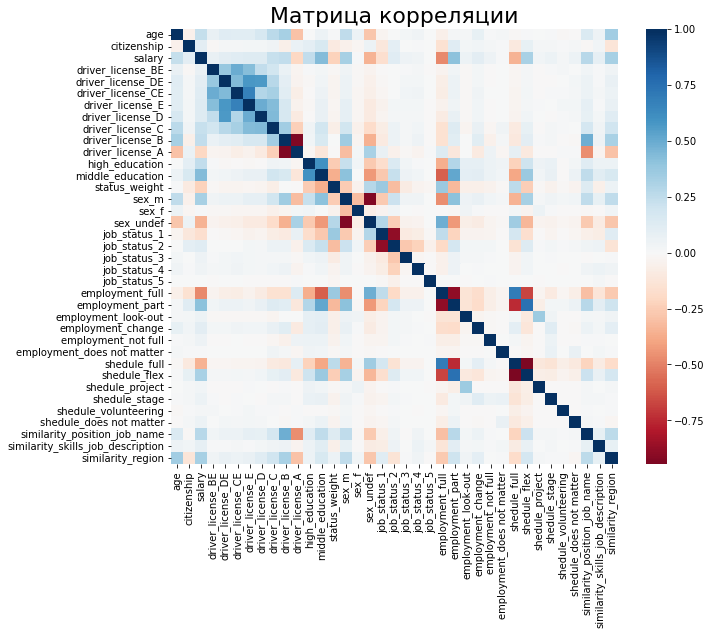

In [39]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    digit_union_df.corr(),
    xticklabels=digit_union_df.corr().columns,
    yticklabels=digit_union_df.corr().columns,
    cmap="RdBu",
    center=0,
)

plt.title("Матрица корреляции", fontsize=22)
plt.show()

In [40]:
 digit_union_df.corr()["status_weight"].sort_values(ascending=False)

status_weight                        1.000000
job_status_1                         0.374890
employment_full                      0.370037
sex_undef                            0.279313
shedule_full                         0.256257
similarity_position_job_name         0.131411
similarity_region                    0.056994
age                                  0.007239
driver_license_B                    -0.001919
driver_license_A                    -0.009589
employment_does not matter          -0.013691
shedule_project                     -0.016600
shedule_volunteering                -0.017170
driver_license_BE                   -0.017281
job_status_5                        -0.020694
driver_license_E                    -0.022044
driver_license_DE                   -0.029144
driver_license_CE                   -0.031254
driver_license_D                    -0.032171
job_status_4                        -0.033189
shedule_does not matter             -0.033348
sex_f                             

Наибольшая корреляция наблюдается в:
положительная
* job_status_1:                         0.362322
* employment_full:                      0.282658
* sex_undef:                            0.263477
* shedule_full:                         0.182544
* similarity_position_job_name:         0.144731

отрицательная 
* salary:                              -0.165630
* shedule_flex:                        -0.169358
* high_education:                      -0.171128
* sex_m:                               -0.221868 
* employment_part:                     -0.240139
* job_status_2:                        -0.270550
* middle_education:                    -0.273050 


Корреляция может быть вызвана нехваткой данных

Проверяем каждую из выбраных корреляций, с учетом исключения данных по которым нехватает данных, например отрицательная корреляция с мужским полом связанна с тем что при у большинства кандидатов не указан пол и в поле sex_m проставляется 0

In [41]:
# Проверяем корреляцию с полом:
# Проверяем корреляцию исключив отсутвующие данные по полу
temp_df = digit_union_df.copy()
temp_df["sex"] = union_df["sex"]
temp_df = temp_df[temp_df["sex"] != 0]

temp_df[["status_weight", "sex_m", "sex_f"]].corr()
# На самом деле корреляция с полом невелика

,status_weight,sex_m,sex_f
status_weight,1.000000,0.024379,-0.024379
sex_m,0.024379,1.000000,-1.000000
sex_f,-0.024379,-1.000000,1.000000


In [42]:
# Проверяем корреляцию с образованием:
# Если образование не указано, то в middle_education и в heigh_education ставиться 0, 
# т.к. много данных без указания образования происходит отрицательная корреляция.
# Можно проверить на сравнении корреляции с выссшим образованием, т.е. когда
# есть высшее или нет у тех у кого уже есть среднее. 
temp_df = digit_union_df.copy()
temp_df = temp_df[temp_df["middle_education"] == 1]
temp_df[["status_weight", "high_education"]].corr()
# Корреляция не велика


,status_weight,high_education
status_weight,1.000000,-0.062391
high_education,-0.062391,1.000000


In [43]:
# Проверка корреляции job_status:
#   - job_status_1: 0.362322
#   - job_status_2: -0.270550
# Status - статус вакансии ( 1 - открытая, 2 - закрытая, 3 - приостановленная, 4 - отменена, 5 - черновик)

t_df = digit_union_df.copy()
t_df[["status_weight", "job_status_1", "job_status_2", "job_status_3", "job_status_4", "job_status_5"]].corr()
# Логика присутвтует, открытых позиций гораздо больше в данных а также вероятность сопоставления вакансии выше если вакансия открыта. 
# Для закрытых ваансий могут поступать отказы от работадателя, даже предлагать хороших кандидатов

,status_weight,job_status_1,job_status_2,job_status_3,job_status_4,job_status_5
status_weight,1.000000,0.374890,-0.310553,-0.083659,-0.033189,-0.020694
job_status_1,0.374890,1.000000,-0.883484,-0.088679,-0.075153,-0.016656
job_status_2,-0.310553,-0.883484,1.000000,-0.268680,-0.227698,-0.050464
job_status_3,-0.083659,-0.088679,-0.268680,1.000000,-0.022855,-0.005065
job_status_4,-0.033189,-0.075153,-0.227698,-0.022855,1.000000,-0.004293
job_status_5,-0.020694,-0.016656,-0.050464,-0.005065,-0.004293,1.000000


In [44]:
# Проверка корреляции employment:
#   - employment_full: 0.282658
#   - employment_part: -0.240139
# Employment - Формат нагрузки (0 - 'Full', 1 - 'Part', 2 - 'Look-out', 3 - 'Change', 4 - 'Not full', 5 - 'does not matter')  
t_df = digit_union_df.copy()
t_df["employment"] = union_df["employment"]

t_df = t_df[t_df["employment"] != 5]
t_df[["status_weight", "employment_full", "employment_part"]].corr()
# Логика присутсвтует, данных с полным трудоустройством гораздо больше чем других, 
# а также работадатели (которые размещают вакансии) чаще заинтересованы в поиске на полную занятость 
# И если есть два кандидата, один готов на полную занятость,  другой на частичную, то вероятность подходячести к вакансии у первого выше

,status_weight,employment_full,employment_part
status_weight,1.000000,0.369973,-0.324416
employment_full,0.369973,1.000000,-0.887864
employment_part,-0.324416,-0.887864,1.000000


In [45]:
# Проверка корреляции shedule:
#   - shedule_full: 0.182544
#   - shedule_flex: -0.169358
# Shedule - Формат занятости (0 - 'Full', 1 - 'Flex', 2 - 'Project', 3 - 'Stage', 4 - 'Volunteering', 5 - 'does not matter')
t_df = digit_union_df.copy()
t_df["shedule"] = union_df["shedule"]

t_df = t_df[t_df["shedule"] != 5]
t_df[["status_weight", "shedule_full", "shedule_flex"]].corr()
# shedule по аналогии с employment:  данных с полным рабочим днем гораздо больше чем других, 
#  а также логика корреляции shedule присутсвтует в том что работадатели (которые размещают вакансии)
#  чаще заинтересованы в поиске на полную рабочий день и при выборе двух кандидатов при прочих равных, 
# вероятность выбора больше у того кто на полный рабочий день



,status_weight,shedule_full,shedule_flex
status_weight,1.000000,0.254928,-0.242896
shedule_full,0.254928,1.000000,-0.955332
shedule_flex,-0.242896,-0.955332,1.000000


In [46]:
# Проверяем корреляцию с предполагаемой зп (salary): salary: -0.165630
# Проверяем корреляцию исключив отсутвующие данные с зп
temp_df = digit_union_df.copy()
temp_df["salary"] = union_df["salary"]
temp_df = temp_df[temp_df["salary"] != 0]

temp_df[["status_weight", "salary"]].corr()
# На самом деле корреляция с зарплатой небольшая

,status_weight,salary
status_weight,1.000000,0.104698
salary,0.104698,1.000000


In [47]:
# Корреляцию со схожестью названий позиции и вакансии
# similarity_position_job_name: 0.144731
# Наименование позиции указано у всех кандидатов, поэтому корреялцию можно считать корректной


### Итог анализа корреляции
Подтверждена корреляция для следующих параметров:
- job_status_1: 0.362322
- employment_full: 0.282658
- shedule_full: 0.182544
- similarity_position_job_name: 0.144731
- shedule_flex: -0.169358
- employment_part: -0.240139
- job_status_2: -0.270550

Однако необходмио учитывать объем данных, так например значений shedule_full и employment_full в принципе гораздо больше в исхдоных данных, т.е. присутсвтует расбалансировка данных по этим параметрам

In [48]:
# digit_union_df[digit_union_df["sex_m"]][["status_weight", "sex_m"]].corr()
t_df = digit_union_df.copy()
t_df["sex"] = union_df["sex"]

# digit_union_df[digit_union_df["sex_m"] != 0].shape, digit_union_df.shape
# t_df = digit_union_df[digit_union_df["sex_m"] != 0]
t_df = t_df[t_df["sex"] != 0]
t_df[["status_weight", "sex_m", "sex_f",]].corr()

,status_weight,sex_m,sex_f
status_weight,1.000000,0.024379,-0.024379
sex_m,0.024379,1.000000,-1.000000
sex_f,-0.024379,-1.000000,1.000000


In [49]:
# # Асимметрия — это мера асимметрии распределения вероятностей действительнозначной случайной величины относительно ее среднего значения.
# pd.DataFrame(digit_union_df.skew().sort_values(ascending=False))

# TensorFlow Модель

## Подготавливаем и преобразовыаем данные

Формируем данные

In [50]:
x_data = digit_union_tokens_df[digit_union_tokens_df.columns.difference(["status_weight"])]
y_data = digit_union_tokens_df["status_weight"]
# Переводим y_data в класификатор вида [0., 1.]
y_data = np.array([[1-weight, weight] for weight in y_data])

x_data.shape, y_data.shape

((122047, 502), (122047, 2))

### Нормализация данных

In [51]:
# Нормализируем следующие параметры: salary и age
x_data.salary = StandardScaler().fit_transform(x_data[["salary"]])
x_data.age = StandardScaler().fit_transform(x_data[["age"]])

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Разбиваем данные на тестовую и обучающую выборки

In [52]:
# Разбиваем данные на train, test, val
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, shuffle=True)
# x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, shuffle=True)

x_train.shape, x_val.shape, y_train.shape, y_val.shape 
#, x_test.shape, y_test.shape

((109842, 502), (12205, 502), (109842, 2), (12205, 2))

## Запускаем модель

In [53]:
# TODO Управление весами 
# class_weight и sample_weight # в fit подавать sample_weight=sample_weight,  class_weight=class_weight 
# Веса выходных классов
# class_weight = {0 : 1. , 1: 3.}
# class_weight
# Веса входных данных (каждая строка данных взвешивается)
# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[y_train != 0] = 2.0

Epoch 1/5
367/367 [==============================] - 50s 129ms/step - loss: 0.2257 - accuracy: 0.9519 - val_loss: 0.2042 - val_accuracy: 0.9621
Epoch 2/5
367/367 [==============================] - 48s 129ms/step - loss: 0.1857 - accuracy: 0.9709 - val_loss: 0.1797 - val_accuracy: 0.9730
Epoch 3/5
367/367 [==============================] - 49s 134ms/step - loss: 0.1764 - accuracy: 0.9744 - val_loss: 0.1855 - val_accuracy: 0.9717
Epoch 4/5
367/367 [==============================] - 46s 126ms/step - loss: 0.1700 - accuracy: 0.9769 - val_loss: 0.1709 - val_accuracy: 0.9766
Epoch 5/5
367/367 [==============================] - 47s 127ms/step - loss: 0.1664 - accuracy: 0.9778 - val_loss: 0.1744 - val_accuracy: 0.9756


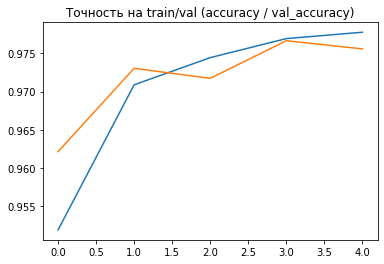

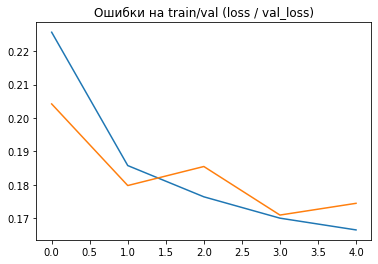

In [54]:
model = Sequential()
model.add(Dense(1400, input_shape=(x_train.shape[1:]), activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(700, activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(500, activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(200, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="softmax"))
model.compile( optimizer="Nadam", loss="binary_crossentropy", metrics=["accuracy"] ) 

history = model.fit( x_train, y_train, epochs=5, validation_data=(x_val, y_val), verbose=True, batch_size=300)

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Точность на train/val (accuracy / val_accuracy)")
plt.show()

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Ошибки на train/val (loss / val_loss)")
plt.show()

# Формируем предикт по тестовым данным

TODO:
 - Перевести обработку данных в класс предобработки и функциями обработку делать и для обучения и для теста

### Загружаем тестовые данные

In [55]:
# Кандидаты
test_filename_candidates = PATH_PROJECT + "dataset/test/" + "test_candidates.csv"
# данные по образованию кандидатов
test_filename_education = PATH_PROJECT + "dataset/test/" + "test_candidates_education.csv"
# места работы кандидатов
test_filename_work_places = PATH_PROJECT + "dataset/test/" + "test_candidates_workplaces.csv"
# Вакансии
test_filename_jobs = PATH_PROJECT + "dataset/test/" + "test_jobs.csv"

In [56]:
test_candidates_df = pd.read_csv(test_filename_candidates, sep=";", names=['id', 'position', 'sex', 	
                                                                 'citizenship', 	'age', 'salary',	
                                                                 'langs', 'driver_license', 'subwey', 
                                                                 'skills', 'employment', 'shedule', 
                                                                 'candidate_region'], skiprows=[0])
test_education_df = pd.read_csv(test_filename_education, sep=";", names=['id', 'university', 'faculty', 'graduate_year'], skiprows=[0])
test_work_places_df = pd.read_csv(test_filename_work_places, sep=";", names=['id', 'work_place_position', 'from_year', 	'from_month', 'to_year', 'to_month'], skiprows=[0])
test_jobs_df = pd.read_csv(test_filename_jobs, sep=";", names=['job_id', 'job_status', 'job_name', 	'job_region', 'job_description',"1", "2", "3"])

test_candidates_df.shape, test_education_df.shape, test_work_places_df.shape, test_jobs_df.shape

((200, 13), (277, 4), (893, 6), (10, 8))

In [57]:
# Удаление дублей по Id
candidates_mask = test_candidates_df.duplicated(subset=["id"])
test_candidates_df = test_candidates_df.loc[~candidates_mask]

education_mask = test_education_df.duplicated(subset=["id"])
test_education_df = test_education_df.loc[~education_mask]

work_places_mask = test_work_places_df.duplicated(subset=["id"])
test_work_places_df = test_work_places_df.loc[~work_places_mask]

jobs_mask = test_jobs_df.duplicated(subset=["job_id"])
test_jobs_df = test_jobs_df.loc[~jobs_mask]


test_candidates_df.shape, test_education_df.shape, test_work_places_df.shape, test_jobs_df.shape

((200, 13), (185, 4), (212, 6), (10, 8))

#### Объединяем кандидата с информацией об обучении и стаже

In [58]:
# объединяем кандидатов с данными об образовании (по "id")
test_union_df = test_candidates_df.merge(test_education_df, how="left", left_on="id", right_on="id")
# объединяем кандидатов с данными об опыте работы (по "id")
test_union_df = test_union_df.merge(test_work_places_df, how="left", left_on="id", right_on="id")

test_union_df.shape

(200, 21)

#### Объединяем каждую вакансию с каждым кандидатом, чтобы в итоге проверить вероятность их совмещения

In [59]:
# объединяем каждого кандидатов с данными по каждой вакансии
test_union_df = test_union_df.merge(test_jobs_df, how='cross')
test_union_df.shape

(2000, 29)

In [60]:
# копия датасета для CatBoostRegressor
test_union = test_union_df.copy()
test_union.head(3)

,id,position,sex,citizenship,age,salary,langs,driver_license,subwey,skills,...,to_year,to_month,job_id,job_status,job_name,job_region,job_description,1,2,3
0,8458568,специалист отдела парковочного комплекса,2,Россия,50,45000,английский:базовые знания||русский:родной||,NaN,NaN,"Ведение документации ,управление производством...",...,2019.0,0.0,140952,2,Водитель автомобиля большегруза с прицепом,Санкт-Петербург,<p><strong>ОБЯЗАННОСТИ:</strong><span></span><...,2197,1,1
1,8458568,специалист отдела парковочного комплекса,2,Россия,50,45000,английский:базовые знания||русский:родной||,NaN,NaN,"Ведение документации ,управление производством...",...,2019.0,0.0,76137,2,водитель на своем авто,Москва,"<p>Начался сезон отпусков, по этой причине отк...",2869,1,1
2,8458568,специалист отдела парковочного комплекса,2,Россия,50,45000,английский:базовые знания||русский:родной||,NaN,NaN,"Ведение документации ,управление производством...",...,2019.0,0.0,119729,4,Водитель,Москва,"<p>Наш клиент, крупный холдинг рассматривает к...",2869,1,1


### Предобработка

In [61]:
test_union_df["position"] = test_union_df["position"].astype({"position": 'str'})
test_union_df["job_name"] = test_union_df["job_name"].astype({"job_name": 'str'})
test_union_df["skills"] = test_union_df["skills"].astype({"skills": 'str'})
test_union_df["job_description"] = test_union_df["job_description"].astype({"job_description": 'str'})

In [62]:
# Будем править Возраст по правилам: если больше > 70, то 70 если меньше 0, то 0, если от 1 до 18 то 18
test_union_df.loc[test_union_df['age'] > 70, 'age'] = 70
test_union_df.loc[test_union_df['age'] < 0, 'age'] = 0
test_union_df.loc[(test_union_df['age'] > 0) & (test_union_df['age'] < 18), 'age'] = 18
test_union_df.age.unique()

array([50, 24, 33, 37, 34, 28, 44, 42,  0, 43, 31, 22, 32, 47, 29, 56, 54,
       48, 36, 51, 40, 53, 55, 46, 19, 23, 45, 38, 26, 39, 49, 25, 35, 30,
       59, 64, 41, 27, 60])

In [63]:
# Будем править Зарплату по правилам: если больше 0 но меньше 20000, то 20000, если больше 200 000 то 200 000
test_union_df.loc[test_union_df['salary'] > 200000, 'salary'] = 200000
test_union_df.loc[(test_union_df['salary'] > 0) & (test_union_df['salary'] < 20000), 'salary'] = 20000
test_union_df.salary.unique()

array([ 45000,  50000,  60000,  70000,      0,  85000,  49000,  80000,
       100000, 120000,  30000,  75000,  35000,  40000,  46000,  48000,
        38000,  55000, 150000,  37000,  95000,  90000,  98000,  65000,
        28000,  25000,  20000])

In [64]:
# для кандидатов водителей ставим по умолчанию права ставим на категорию "B"
test_union_df.loc[test_union_df['position'].astype(str).str.contains("Водит|водит|авто|дитель|такс|ВОДИТ|Перегон|ПЕРЕГОН|перегон|Трактор|ТРАКТОР|трактор|Перевоз|ПЕРЕВОЗ|перевоз"), 'driver_license'] = test_union_df.loc[test_union_df['position'].astype(str).str.contains("Водит|водит|авто|дитель|такс|ВОДИТ|Перегон|ПЕРЕГОН|перегон|Трактор|ТРАКТОР|трактор|Перевоз|ПЕРЕВОЗ|перевоз"), 'driver_license'].fillna("B")

In [65]:
# Права могут быть различных категорий, указываем каждый тип прав как отдельны столбец
test_union_df['driver_license_BE'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("BE|Be|bE|be|ВЕ|ве|Ве|вЕ") , 1, 0)
test_union_df['driver_license_DE'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("DE|de|De|dE|DЕ|dе|Dе|dЕ") , 1, 0)
test_union_df['driver_license_CE'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("CE|ce|Ce|cE|СЕ|се|Се|сЕ") , 1, 0)
test_union_df['driver_license_E'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("E|e|Е|е") , 1, 0)
test_union_df['driver_license_D'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("D|d") , 1, 0)
test_union_df['driver_license_C'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("C|c|С|с") , 1, 0)
test_union_df['driver_license_B'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("B|b|В|в") , 1, 0)
test_union_df['driver_license_A'] = np.where(test_union_df['driver_license'].astype(str).str.lower().str.contains("A|a|А|а") , 1, 0)

In [66]:
# Корректируем данные по Образованию
test_union_df['high_education'] = np.where(test_union_df['university'].astype(str).str.contains("Унив|УНИВ|унив|Инст|инст|ИНСТ|акад|Акад|АКАД|МИ|НИУ|МЭ|МИ|МА|МГ|МТ|МУ|МК|МП") | test_union_df['faculty'].astype(str).str.contains("Унив|УНИВ|унив|Инст|инст|ИНСТ|акад|Акад|АКАД|МИ|НИУ|МЭ|МИ|МА|МГ|МТ|МУ|МК|МП") , 1, 0)
test_union_df['middle_education'] = np.where(test_union_df['university'].notnull() & ~test_union_df['university'].astype(str).str.contains("СОШ|сош|школ|ШК|Школ|ШКОЛ|СШ"), 1, 0)

In [67]:
test_union_df.shape

(2000, 39)

## Оцифровка параметров

In [68]:
# Перевод значений параметров для жестких словарей в отдельные самостоятельные параметры
# Т.е. вместо параметра "sex" будут 'sex_m', 'sex_f', 'sex_undef',

# sex
for key_sex in sex_numeric:
  feture_name = f"sex_{key_sex.lower()}"
  test_union_df[feture_name] = np.where( (test_union_df.sex  == sex_numeric[key_sex]) | (test_union_df.sex  == key_sex) , 1, 0)

# job_status
index_status = 1
for key_status in job_status_numeric:
  # Здесь используем цифру а не сам стсатус, т.к. статус на русском языке
  feture_name = f"job_status_{index_status}"
  test_union_df[feture_name] = np.where((test_union_df.job_status  == job_status_numeric[key_status]) | (test_union_df.job_status  == key_status) , 1, 0)
  index_status += 1

# employment
for key_employ in employment_numeric:
  feture_name = f"employment_{key_employ.lower()}"
  test_union_df[feture_name] = np.where((test_union_df.employment  == employment_numeric[key_employ]) | (test_union_df.employment  == key_employ) , 1, 0)

# shedule
for key_shedule in shedule_numeric:
  feture_name = f"shedule_{key_shedule.lower()}"
  test_union_df[feture_name] = np.where((test_union_df.shedule  == shedule_numeric[key_shedule]) |(test_union_df.shedule  == key_shedule) , 1, 0)

# ['sex_m', 'sex_f', 'sex_undef', 'job_status_1', 'job_status_2', 'job_status_3', 'job_status_4', 'job_status_5', 'employment_full', 'employment_part', 'employment_look-out', 'employment_change', 'employment_not full', 'employment_does not matter', 'shedule_full', 'shedule_flex', 'shedule_project', 'shedule_stage', 'shedule_volunteering', 'shedule_does not matter']

In [69]:
# Гражданство

for word in test_union_df.citizenship.unique():
  test_union_df.loc[(test_union_df.citizenship == word), 'citizenship'] = citizenship_numeric(str(word))
# Если вдруг не удалось обработать NaN, дополнительно проверяем через встроенную функцию
test_union_df.citizenship = test_union_df.citizenship.fillna(1)
test_union_df.citizenship.unique()

array([1, 0])

In [70]:
digit_test_union_df = test_union_df[['age', 'citizenship', 'salary', 'driver_license_BE', 'driver_license_DE', 'driver_license_CE', 
                           'driver_license_E', 'driver_license_D', 'driver_license_C', 'driver_license_B', 'driver_license_A',
                           "high_education","middle_education",
                           'sex_m', 'sex_f', 'sex_undef', 'job_status_1', 'job_status_2', 'job_status_3', 'job_status_4', 'job_status_5', 
                           'employment_full', 'employment_part', 'employment_look-out', 'employment_change', 'employment_not full', 
                           'employment_does not matter', 'shedule_full', 'shedule_flex', 'shedule_project', 'shedule_stage', 
                           'shedule_volunteering', 'shedule_does not matter',
                           ]]
digit_test_union_df.shape

(2000, 33)

### Обработка названия вакансии и наименования позици кандидата

In [71]:
# Обработка навыков кандидата
skills_words = test_union_df['skills'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))


skills_word_tokens = skills_vectorizer.transform(skills_words)
skills_word_tokens.toarray().shape

df_skills_word_tokens = pd.DataFrame(skills_word_tokens.todense(), columns=skills_vectorizer.get_feature_names())
digit_test_union_df = pd.concat([digit_test_union_df, df_skills_word_tokens], axis=1)
digit_test_union_df.shape



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


(2000, 143)

In [72]:
# Обработка описания позиции
job_description_words = test_union_df['job_description'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))

job_description_words_tokens = job_description_vectorizer.transform(job_description_words)
job_description_words_tokens.toarray().shape

df_job_description_words_tokens = pd.DataFrame(job_description_words_tokens.todense(), columns=job_description_vectorizer.get_feature_names())
digit_test_union_df = pd.concat([digit_test_union_df, df_job_description_words_tokens], axis=1)
digit_test_union_df.shape

(2000, 460)

In [73]:
# Обработка названия вакансии и наименования позици кандидата
test_union_df["position"] = test_union_df["position"].astype({"position": 'str'})
position_words = test_union_df['position'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))
job_name_words = test_union_df['job_name'].apply(lambda x: " ".join([snowball.stem(item) for item in re.findall(r"(\w+)",x) if len(item)>4 and  item not in rus_stopwords]))
position_job_name_words = position_words + job_name_words

position_job_name_words_tokens = position_job_name_vectorizer.transform(position_job_name_words)
position_job_name_words_tokens.toarray().shape

df_position_job_name_words_tokens = pd.DataFrame(position_job_name_words_tokens.todense(), columns=position_job_name_vectorizer.get_feature_names())
digit_test_union_df = pd.concat([digit_test_union_df, df_position_job_name_words_tokens], axis=1)
digit_test_union_df.shape

(2000, 499)

In [74]:
# Формирование параметров схожести:
# - схожести названия вакансии и наименования позиции соискателя
test_union_df["position_words"] = position_words
test_union_df["job_name_words"] = job_name_words
# similarity_position_job_name = test_union_df.apply(lambda x: difflib.SequenceMatcher(None, x.position_words, x.job_name_words).quick_ratio(), axis=1)
similarity_position_job_name = test_union_df.apply(lambda x: tanimoto(x.job_name_words, x.position_words), axis=1)

digit_test_union_df['similarity_position_job_name'] = similarity_position_job_name
test_union_df['similarity_position_job_name'] = similarity_position_job_name


# - схожести описания вакансии и навыков соискателя
test_union_df["job_description_words"] = job_description_words
test_union_df["skills_words"] = skills_words
# similarity_skills_job_description = test_union_df.apply(lambda x: difflib.SequenceMatcher(None, x.skills_words, x.job_description_words).quick_ratio(), axis=1)
similarity_skills_job_description = test_union_df.apply(lambda x: tanimoto(x.skills_words, x.job_description_words), axis=1)
digit_test_union_df['similarity_skills_job_description'] = similarity_skills_job_description
test_union_df['similarity_skills_job_description'] = similarity_skills_job_description


# - схожесть регионов
test_union_df['job_region'] = test_union_df['job_region'].fillna("")
test_union_df['candidate_region'] = test_union_df['candidate_region'].fillna("")
# similarity_region = test_union_df.apply(lambda x: difflib.SequenceMatcher(None, x.job_region, x.candidate_region).quick_ratio(), axis=1)
similarity_region = test_union_df.apply(lambda x: tanimoto(x.job_region, x.candidate_region), axis=1)
digit_test_union_df['similarity_region'] = similarity_region
test_union_df['similarity_region'] = similarity_region



 ## Формируем предикт для тестовых данных

In [75]:
x_test_from_file = digit_test_union_df


In [76]:
# Нормализируем следующие параметры: salary и age
x_test_from_file.salary = StandardScaler().fit_transform(x_test_from_file[["salary"]])
x_test_from_file.age = StandardScaler().fit_transform(x_test_from_file[["age"]])

In [77]:
predict = model.predict(x_test_from_file)
test_union_df["predict_TensorFlow"] =  predict[:,1]
predict

array([[9.9997270e-01, 2.7287822e-05],
       [1.0000000e+00, 6.7525380e-10],
       [1.0000000e+00, 2.1940835e-08],
       ...,
       [1.0000000e+00, 3.7332852e-09],
       [9.9999988e-01, 7.7527801e-08],
       [9.9998713e-01, 1.2817985e-05]], dtype=float32)

In [78]:
predict

array([[9.9997270e-01, 2.7287822e-05],
       [1.0000000e+00, 6.7525380e-10],
       [1.0000000e+00, 2.1940835e-08],
       ...,
       [1.0000000e+00, 3.7332852e-09],
       [9.9999988e-01, 7.7527801e-08],
       [9.9998713e-01, 1.2817985e-05]], dtype=float32)

In [79]:
predict_analize = test_union_df[["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region",  "predict_TensorFlow" ]] 
predict_analize.sort_values(by="predict_TensorFlow", ascending = False)

,id,position,skills,candidate_region,job_id,job_name,job_description_words,job_region,predict_TensorFlow
1355,10413290,Водитель-экспедитор,Автомобильные грузоперевозки || Экспедирование...,Москва,94661,водитель на личном авто,курьер выходн сво,Москва,9.994650e-01
1358,10413290,Водитель-экспедитор,Автомобильные грузоперевозки || Экспедирование...,Москва,165605,Менеджер по продажам,обязан работ имеющ клиентск баз поиск нов поте...,Санкт-Петербург,9.994586e-01
1359,10413290,Водитель-экспедитор,Автомобильные грузоперевозки || Экспедирование...,Москва,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,9.994541e-01
1351,10413290,Водитель-экспедитор,Автомобильные грузоперевозки || Экспедирование...,Москва,76137,водитель на своем авто,нача сезон отпуск причин открыва дополнительн ...,Москва,9.991956e-01
1357,10413290,Водитель-экспедитор,Автомобильные грузоперевозки || Экспедирование...,Москва,157891,водитель курьер на авто компании,водител компан заказ возмещен час график гибк ...,Москва,9.991192e-01
...,...,...,...,...,...,...,...,...,...
1626,10643426,"Водитель В,С,D, тракторист кат. Е",Безаварийное вождение || Пользователь ПК || Ре...,Санкт-Петербург,120695,Водитель-экспедитор 1/ Водитель,strong обязан strong доставк бытов техник элек...,Москва,6.484055e-16
1116,10297612,"Водитель персональный, семейный",Водительский стаж более 20 лет || Аккуратное в...,Москва,120695,Водитель-экспедитор 1/ Водитель,strong обязан strong доставк бытов техник элек...,Москва,4.883083e-16
856,8770936,Водитель,Вождение автомобилей представительского класса...,Санкт-Петербург,120695,Водитель-экспедитор 1/ Водитель,strong обязан strong доставк бытов техник элек...,Москва,1.886852e-16
1117,10297612,"Водитель персональный, семейный",Водительский стаж более 20 лет || Аккуратное в...,Москва,157891,водитель курьер на авто компании,водител компан заказ возмещен час график гибк ...,Москва,4.811393e-17


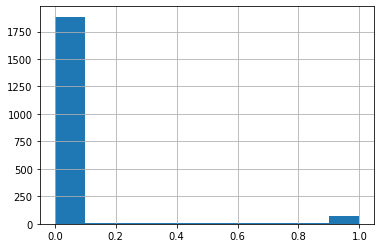

In [80]:
# Распределение предикта
predict_analize["predict_TensorFlow"].hist()

In [81]:
predict_analize[predict_analize["predict_TensorFlow"] > 0.9]

,id,position,skills,candidate_region,job_id,job_name,job_description_words,job_region,predict_TensorFlow
39,8511459,Агент по обработке авиаперевозок,способность заниматься несколькими проектами |...,Москва,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,0.996493
49,8530237,Техник-механик,Активная позиция || ПК. Excel. Word || Трактор...,Санкт-Петербург,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,0.991064
465,13162978,Кладовщик,Приемка груза || Контроль отгрузок || Работа с...,Московская область,94661,водитель на личном авто,курьер выходн сво,Москва,0.961116
469,13162978,Кладовщик,Приемка груза || Контроль отгрузок || Работа с...,Московская область,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,0.998008
485,13244496,"Оператор склада, комплектовщик ричтрак",Водительские права на ричтрак || Большой опыт ...,Московская область,94661,водитель на личном авто,курьер выходн сво,Москва,0.935694
...,...,...,...,...,...,...,...,...,...
1744,11304504,водитель,Обучаемость || Работа в команде || Ведение пер...,Ленинградская область,63795,Водитель,обязан качествен доставк японск кухн автомобил...,Санкт-Петербург,0.932136
1819,136,"Продавец-консультант, менеджер по продажам",nan,Санкт-Петербург,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,0.914257
1839,143,"Продавец-консультант, Менеджер по продажам, пр...",Активные продажи || Управление продажами ||,Санкт-Петербург,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,0.977467
1919,286,"Продавец-кассир, менеджер по продажам",nan,Санкт-Петербург,241719,Водитель-экспедитор,strong задач strong доставк товар торгов площа...,Москва,0.914587


# Модель - CatBoostRegressor

In [82]:
union_df_cat = union.fillna(0)
union_df_cat[['position']] = union_df_cat[['position']].astype({'position': 'str'})
union_df_cat[['employment']] = union_df_cat[['employment']].astype({'employment': 'str'})
union_df_cat[['shedule']] = union_df_cat[['shedule']].astype({'shedule': 'str'})
union_df_cat[['driver_license']] = union_df_cat[['driver_license']].astype({'driver_license': 'str'})
union_df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122047 entries, 0 to 122046
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   122047 non-null  int64  
 1   position             122047 non-null  object 
 2   sex                  122047 non-null  int64  
 3   citizenship          122047 non-null  object 
 4   age                  122047 non-null  int64  
 5   salary               122047 non-null  int64  
 6   langs                122047 non-null  object 
 7   driver_license       122047 non-null  object 
 8   subwey               122047 non-null  object 
 9   skills               122047 non-null  object 
 10  employment           122047 non-null  object 
 11  shedule              122047 non-null  object 
 12  candidate_region     122047 non-null  object 
 13  date_created         122047 non-null  object 
 14  job_id               122047 non-null  int64  
 15  candidate_status_

Для CatBoost-модели - без изменения категориальных признаков

In [83]:
x_data_cat = union_df_cat[['position', 'driver_license', 'sex', 'age', 'salary', 'employment', 'shedule', 'from_year', 'to_year', 'job_status' ]]
y_data_cat = union_df_cat[["status_weight"]]

x_data_cat.shape, y_data_cat.shape

((122047, 10), (122047, 1))

**CatBoost** - Определяем входные параметры X и значения целевой функции Y (таргет)

In [84]:
x_train_cat, x_test_cat, y_train_cat, y_test_cat = train_test_split(x_data_cat, y_data_cat, test_size=0.3, random_state=12345, shuffle=True)
x_train_cat, x_val_cat, y_train_cat, y_val_cat = train_test_split(x_train_cat, y_train_cat, test_size=0.3, random_state=12345, shuffle=True)

x_train_cat.shape, x_test_cat.shape, y_train_cat.shape, y_test_cat.shape, x_val_cat.shape, y_val_cat.shape

((59802, 10), (36615, 10), (59802, 1), (36615, 1), (25630, 10), (25630, 1))

In [85]:
x_train_cat.head()

,position,driver_license,sex,age,salary,employment,shedule,from_year,to_year,job_status
49417,Водитель-экспедитор,BC,2,41,0,Part,0,2017.0,2021.0,2
58294,Личный охранник,0,2,0,120000,Look-out,0,2011.0,2012.0,2
84097,Водитель,0,2,35,0,Full,Full,0.0,0.0,2
101355,Таксист,0,2,34,0,0,0,0.0,0.0,4
94976,официант,0,1,18,0,Full,Full,0.0,0.0,2


## Модель CatBoostRegressor

In [86]:
# выбираем категориальные столбцы
columns = ['position', 'driver_license', 'employment', 'shedule']

In [87]:
cat_model = CatBoostRegressor(
    cat_features=columns,
    bagging_temperature=1, # 1
    random_strength=1, # 0
    thread_count=2, # 1
    iterations=150, #1200
    loss_function='RMSE', #RMSE
    l2_leaf_reg = 1.0,  # 6.0 
    learning_rate = 0.095, # 0.085
    save_snapshot=False,
    random_seed=110, # 110
    od_type='Iter',
    od_wait=100, # 150
    custom_metric=['AUC:hints=skip_train~false']
)

In [88]:
# grid = {'learning_rate': [0.03, 0.1],
#         'depth': range(4, 10, 2),
#         'l2_leaf_reg': range(1, 10, 2),
#         'od_wait': [100]}

grid = {'learning_rate': [0.03],
        'depth': range(4, 6),
        'l2_leaf_reg': range(1, 6, 2)}
        
grid_search_result = cat_model.grid_search(grid, X=x_train_cat, y=y_train_cat, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6271549	test: 0.6326720	best: 0.6326720 (0)	total: 90.9ms	remaining: 13.5s
1:	learn: 0.6161444	test: 0.6216482	best: 0.6216482 (1)	total: 114ms	remaining: 8.46s
2:	learn: 0.6057082	test: 0.6112304	best: 0.6112304 (2)	total: 140ms	remaining: 6.86s
3:	learn: 0.5957131	test: 0.6012525	best: 0.6012525 (3)	total: 159ms	remaining: 5.8s
4:	learn: 0.5860642	test: 0.5915982	best: 0.5915982 (4)	total: 183ms	remaining: 5.31s
5:	learn: 0.5768783	test: 0.5824023	best: 0.5824023 (5)	total: 204ms	remaining: 4.91s
6:	learn: 0.5679990	test: 0.5735019	best: 0.5735019 (6)	total: 227ms	remaining: 4.65s
7:	learn: 0.5596242	test: 0.5651160	best: 0.5651160 (7)	total: 247ms	remaining: 4.38s
8:	learn: 0.5516677	test: 0.5571453	best: 0.5571453 (8)	total: 264ms	remaining: 4.14s
9:	learn: 0.5439693	test: 0.5494338	best: 0.5494338 (9)	total: 284ms	remaining: 3.97s
10:	learn: 0.5365958	test: 0.5420494	best: 0.5420494 (10)	total: 321ms	remaining: 4.05s
11:	learn: 0.5296775	test: 0.5351076	best: 0.5351076

In [89]:
cat_model.best_score_

{'learn': {'RMSE': 0.28323030897236273, 'AUC': 0.9202095048800194}}

Проверка на тестовой выборке встроенной метрикой R2

In [ ]:
result1 = cat_model.score(x_test_cat, y_test_cat)
result1

Альтернативный способ подбора параметров для CatBoostRegressor

In [ ]:
# cat_model.get_params()

In [ ]:
# from catboost import Pool, cv

# params = cat_model.get_params()
# pool1 = Pool(data=x_train_cat, label=y_train_cat, cat_features=columns)

In [ ]:
# cv_data = cv(
#    params = params,
#    pool = pool1,
#    fold_count=10,
#    inverted=False,
#    shuffle=True,
#    stratified=True,
#    partition_random_seed=5
# )

Проверка на тестовой выборке встроенной метрикой R2

In [ ]:
# result2 = cat_model.score(x_test_cat, y_test_cat)
# result2

Вывод: очень противоречивые результаты получились - RMSE небольшой, а R2 очень плохо характеризует результаты работы обученной модели на тесте. В то время, как AUC-ROC не так уж и плох.

## Предсказание по тестовым данным

In [ ]:
test_union_cat = test_union.fillna(0)
test_union_cat[['position']] = union_df_cat[['position']].astype({'position': 'str'})
test_union_cat[['employment']] = union_df_cat[['employment']].astype({'employment': 'str'})
test_union_cat[['shedule']] = union_df_cat[['shedule']].astype({'shedule': 'str'})
test_union_cat[['driver_license']] = union_df_cat[['driver_license']].astype({'driver_license': 'str'})
test_union_cat = test_union_cat[test_union_cat.columns[:-3]]
test_union_cat.columns

In [ ]:
x_test_cat = test_union_cat[['position', 'driver_license', 'sex', 'age', 'salary', 'employment', 'shedule', 'from_year', 'to_year', 'job_status' ]]
x_test_cat.shape

In [ ]:
predict_cat = cat_model.predict(x_test_cat)
predict_cat

In [ ]:
# добавляем предикт catboost к сводной таблице
test_union_df["predict_CatBoost"] = predict_cat

In [ ]:
# predict_cat = pd.DataFrame(data=predict_cat, index=x_test_cat.index, columns=['pred'], dtype='float')
# predict_cat

In [ ]:
# predict_cat.max(), predict_cat.min(), predict_cat.mean()

In [ ]:
# predict_cat.hist(bins=50)

In [ ]:
# predict_cat.boxplot()

# Сводная таблица по предсказаниям

In [ ]:
# x = test_union_cat[['candidate_region', 'job_region']]
# x

In [ ]:
# predict_fin = pd.DataFrame(data=predict, index=x_test_from_file.index, columns=['max', 'min'], dtype='float')
# predict_fin

In [ ]:
# table = predict_cat.merge(predict_fin, left_index=True, right_index=True)
# table = table.merge(x, left_index=True, right_index=True)
# table

In [ ]:
# result_job_df = test_union_df[test_union_df["job_id"] == 140952][["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region", "similarity_region", "similarity_position_job_name","similarity_skills_job_description", "predict_TensorFlow", "predict_CatBoost"]]
# result_job_df.shape

In [ ]:
# result_job_df

# Генератор результирующих файлов

Учитывая, что модели обучались на данных которые были изначально смержины между вакансиями, соответсвтенно модели не смогут определить этот критерий. 
Немного им поможем:
```
Приоритет 1: схожесть регионов
Приоритет 2: схожесть наименования вакансии и желаемой позиции
Приоритет 3: предикты двух моделей (Tensorflow + Catboost) + схожесть описания вакансии 
```
Сортировка будет дискретная в зависимости от уровня схожести региона и наименования вакансии. Процент точности будет расставлен по итогу сортировки, в порядке убывания
```
1ый Этап сортировки:
	Регионы равны similarity_region = 1
	\
	  similarity_position_job_name >= 0.75 + сортировка 
	      \
	        сортировка predict (C+t)/2+d/3  
	Затем другие регионы 
	\
	 similarity_position_job_name >= 0.75 + сортировка 
		 \
		  сортировка predict (C+t)/2+d/3  
2ой и последующие Этапы сортировки:
	Затем Регионы равны similarity_region = 1
	\ 
	   similarity_position_job_name >= 0.50 + сортировка 
	       \ 
	         сортировка predict (C+t)/2+d/3  
	Затем другие регионы 
	\
	   similarity_position_job_name >= 0.50 + сортировка 
	       \ 
	         сортировка predict (C+t)/2+d/3

```




In [ ]:

def get_sort_candidats(result_job_df):
  sorted_candidats = []
  # 1 приоритет
  df_p1 = result_job_df[(result_job_df["similarity_region"] == 1) & (result_job_df["similarity_position_job_name"] >=0.75)].sort_values(by=["union_predict"], ascending=False)
  # print(df_p1["id"].values)
  sorted_candidats += list(df_p1["id"].values)
  # 2 приоритет
  df_p2 = result_job_df[(result_job_df["similarity_region"] < 1) & (result_job_df["similarity_position_job_name"] >=0.75)].sort_values(by=["union_predict"], ascending=False)
  sorted_candidats += list(df_p2["id"].values)
  # 3 приоритет
  df_p3 = result_job_df[(result_job_df["similarity_region"] == 1) & (result_job_df["similarity_position_job_name"] >=0.50) & (result_job_df["similarity_position_job_name"] < 0.75)].sort_values(by=["union_predict"], ascending=False)
  sorted_candidats += list(df_p3["id"].values)
  # 4 приоритет
  df_p4 = result_job_df[(result_job_df["similarity_region"] < 1) & (result_job_df["similarity_position_job_name"] >=0.50) & (result_job_df["similarity_position_job_name"] < 0.75)].sort_values(by=["union_predict"], ascending=False)
  sorted_candidats += list(df_p4["id"].values)
  # 5 приоритет
  df_p5 = result_job_df[(result_job_df["similarity_position_job_name"] < 0.50)].sort_values(by=["union_predict"], ascending=False)
  sorted_candidats += list(df_p5["id"].values)
  return sorted_candidats

In [ ]:
def sorted_candidats(result_job_df):

  def calc_bonus_fine(sim_region, sim_position, src_predict):
    fine_position = 0.10
    bonus_position = 0.5
    fine_region = 0.7
    bonus_region = 0.03
    if sim_region == 1:
      src_predict += bonus_region
    else:
      src_predict -= fine_region

    if sim_position > 0.75:
      src_predict += bonus_position
    elif sim_position > 0.50: 
      src_predict += bonus_position/2
    elif sim_position < 0.30: 
      src_predict -= fine_position
    return src_predict



  # result_job_df["combination_predict"] = result_job_df["predict_Tensorflow_CatBoost"]
  # print(result_job_df["combination_predict"])
  # test_union_df.apply(lambda x: tanimoto(x.job_name_words, x.position_words), axis=1)
  print(result_job_df.columns)
  result_job_df["combination_predict"] = result_job_df.apply(lambda x: calc_bonus_fine(x.similarity_region, x.similarity_position_job_name, x.predict_Tensorflow_CatBoost), axis=1 )

  # нормализируем предикт между 0 и 1, т.к. из-за штрафов могут быть и отрицательные показаетели
  result_job_df.combination_predict = (result_job_df.combination_predict - result_job_df.combination_predict.min() + 0.01)/((result_job_df.combination_predict.max()+0.05)-result_job_df.combination_predict.min())

  return result_job_df.sort_values(by="combination_predict", ascending=False)
                                                             
  # print(result_job_df)
  # result_job_df
  #  result_job_df[(result_job_df["similarity_region"] == 1) & (result_job_df["similarity_position_job_name"] >=0.75)].sort_values(by=["union_predict"], ascending=False)

test_union_df["predict_Tensorflow_CatBoost"] = (test_union_df["predict_TensorFlow"] + test_union_df["predict_CatBoost"])/2
result_job_df = test_union_df[["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region", "predict_Tensorflow_CatBoost",  "predict_TensorFlow", "predict_CatBoost", "similarity_position_job_name",  "similarity_region" ]] 
df_sorted_candidats = sorted_candidats(result_job_df[result_job_df["job_id"] == 140952])
df_sorted_candidats

In [ ]:
result_job_df[["predict_TensorFlow", "predict_CatBoost", "predict_Tensorflow_CatBoost", "similarity_position_job_name",  "similarity_region"]].hist()


In [ ]:
# test_union_df["predict_Tensorflow_CatBoost"] = (test_union_df["predict_TensorFlow"] + test_union_df["predict_CatBoost"])/2
# result_job_df = test_union_df[["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region", "similarity_position_job_name",  "similarity_region", "predict_Tensorflow_CatBoost",  "predict_TensorFlow", "predict_CatBoost" ]] 
# result_job_df.sort_values(by="predict_Tensorflow_CatBoost", ascending = False)

In [ ]:
test_union_df["predict_Tensorflow_CatBoost"] = (test_union_df["predict_TensorFlow"] + test_union_df["predict_CatBoost"])/2

# Формирование выходных файлов 
for job_id in test_jobs_df["job_id"].values:
  # result_job_df = test_union_df[test_union_df["job_id"] == job_id][["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region",  "similarity_position_job_name_0", "similarity_position_job_name_1", "similarity_position_job_name_2", "similarity_position_job_name_3", "similarity_position_job_name_4", "similarity_region", "similarity_skills_job_description", "predict_TensorFlow", "predict_CatBoost"]]
  result_job_df = test_union_df[test_union_df["job_id"] == job_id][["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region",  "similarity_position_job_name",  "similarity_region", "similarity_skills_job_description", "predict_TensorFlow", "predict_CatBoost", "predict_Tensorflow_CatBoost"]]
  # result_job_df["union_predict"] = (result_job_df["predict_TensorFlow"] + result_job_df["predict_CatBoost"])/2 + result_job_df["similarity_skills_job_description"]/4
  
#   test_union_df["predict_Tensorflow_CatBoost"] = (test_union_df["predict_TensorFlow"] + test_union_df["predict_CatBoost"])/2
# result_job_df = test_union_df[["id","position","skills", "candidate_region", "job_id", "job_name",  "job_description_words" , "job_region", "predict_Tensorflow_CatBoost",  "predict_TensorFlow", "predict_CatBoost", "similarity_position_job_name",  "similarity_region" ]] 
# df_sorted_candidats = sorted_candidats(result_job_df[result_job_df["job_id"] == 140952])


  # result_job_df.to_csv(PATH_PROJECT + "/dataset/result/" + f"pre_res_{job_id}__4.csv", sep=";", encoding="utf-8-sig")
  # sorted_candidats = get_sort_candidats(result_job_df)
  df_sorted_candidats = sorted_candidats(result_job_df[result_job_df["job_id"] == job_id])
  print(df_sorted_candidats.head(10))
  df_sorted_candidats.to_csv(PATH_PROJECT + "/dataset/result/change_result/" + f"result_job_{job_id}.csv", columns=["id", "combination_predict"], header=False, index=False, sep=";")
  # sep

  # with open(PATH_PROJECT + "/dataset/result/" + f"result_job_{job_id}.txt", 'w') as file:
  #   file.write(str_result_file)


In [ ]:
df_sorted_candidats.head(10)